# RoBERTa-base with SMOTE and Hyperparameter Tuning
This notebook loads the data, preprocesses it, vectorizes using a pretrained `roberta-base` model from HuggingFace, applies SMOTE for class imbalance, and performs hyperparameter tuning.

In [1]:
#!pip install -q transformers datasets imbalanced-learn scikit-learn

In [2]:
#!pip install matplotlib
#!pip install torch 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import(
   compute_class_weight,
)
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoConfig,
    DataCollatorWithPadding,
    RobertaForSequenceClassification
)
import torch



from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Get pooled embeddings instead of input_ids for SMOTE
from transformers import RobertaModel
import torch

from transformers import RobertaTokenizer

from imblearn.over_sampling import SMOTE


/Users/joshuawehr/Library/Mobile Documents/com~apple~CloudDocs/NOVA IMS/2n Semester/Text Mining/textmining/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

# Load train data
#train_path = "/content/drive/MyDrive/Text Mining/textmining/Project Data-20250507/train.csv"
train_path = "Project Data-20250507/train.csv"
train_df = pd.read_csv(train_path)

# View shape and features
print("Training data shape:", train_df.shape)
print("\nTraining data columns:", train_df.columns.tolist())

# Display first few rows
print("\nFirst 5 rows of training data:")
train_df.head()

Training data shape: (9543, 2)

Training data columns: ['text', 'label']

First 5 rows of training data:


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [5]:
# Clean text
def preprocess_text(text):
    return text.lower().strip().replace('\n', ' ')

train_df['text'] = train_df['text'].apply(preprocess_text)

# Display first few rows after cleaning
print("\nFirst 5 rows of clean training data:")
train_df.head()


First 5 rows of clean training data:


,text,label
0,$bynd - jpmorgan reels in expectations on beyo...,0
1,$ccl $rcl - nomura points to bookings weakness...,0
2,"$cx - cemex cut at credit suisse, j.p. morgan ...",0
3,$ess: btig research cuts to neutral https://t....,0
4,$fnko - funko slides after piper jaffray pt cu...,0


In [6]:
#import pandas as pd

# Load dataset (update path if needed)
#df = pd.read_csv("train.csv")

# Basic cleanup if needed
train_df.dropna(subset=['text', 'label'], inplace=True)
train_df['label'] = train_df['label'].astype(int)

# Split data
from sklearn.model_selection import train_test_split
X = train_df['text'].tolist()
y = train_df['label'].tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:


tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize function
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

# Tokenize training and validation
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)


In [8]:


model_eval = RobertaModel.from_pretrained('roberta-base')
model_eval.eval()

with torch.no_grad():
    train_embeddings = model_eval(**tokenizer(X_train, padding=True, truncation=True, return_tensors="pt", max_length=128)).last_hidden_state[:,0,:].numpy()

# Reduce dimensionality before SMOTE
scaled_embeddings = StandardScaler().fit_transform(train_embeddings)
X_reduced = PCA(n_components=50).fit_transform(scaled_embeddings)

# Now apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_reduced, y_train)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from torch.utils.data import Dataset

class RobertaDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets for Trainer
train_dataset = RobertaDataset(tokenizer(X_train, truncation=True, padding=True, max_length=128), y_train)
val_dataset = RobertaDataset(tokenizer(X_val, truncation=True, padding=True, max_length=128), y_val)


In [10]:
#pip install 'accelerate>=0.26.0'


In [11]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from transformers import TrainingArguments


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='macro'),
        'precision': precision_score(labels, preds, average='macro'),
        'recall': recall_score(labels, preds, average='macro')
    }

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/joshuawehr/Library/Mobile Documents/com~apple~CloudDocs/NOVA IMS/2n Semester/Text Mining/textmining/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.475000
1000,0.257500


/Users/joshuawehr/Library/Mobile Documents/com~apple~CloudDocs/NOVA IMS/2n Semester/Text Mining/textmining/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1434, training_loss=0.3044004187590574, metrics={'train_runtime': 502.0227, 'train_samples_per_second': 45.619, 'train_steps_per_second': 2.856, 'total_flos': 1223995396976352.0, 'train_loss': 0.3044004187590574, 'epoch': 3.0})

/Users/joshuawehr/Library/Mobile Documents/com~apple~CloudDocs/NOVA IMS/2n Semester/Text Mining/textmining/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation Metrics:
{'test_loss': 0.4195728600025177, 'test_accuracy': 0.8889470927187009, 'test_f1': 0.8596391068045469, 'test_precision': 0.8499181258425997, 'test_recall': 0.870410064584822, 'test_runtime': 8.1854, 'test_samples_per_second': 233.219, 'test_steps_per_second': 14.66}

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       288
           1       0.84      0.87      0.86       385
           2       0.93      0.91      0.92      1236

    accuracy                           0.89      1909
   macro avg       0.85      0.87      0.86      1909
weighted avg       0.89      0.89      0.89      1909

F1 Score (macro): 0.8596391068045469


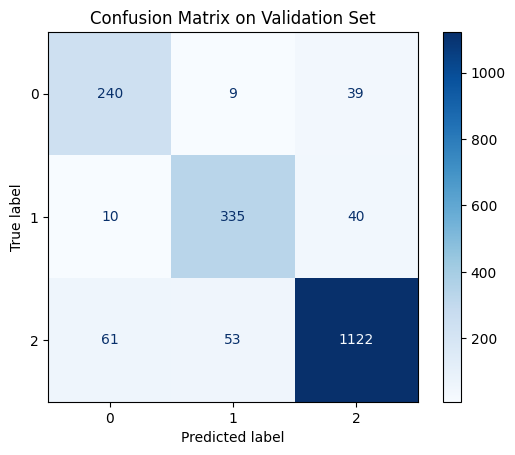

In [13]:
# Evaluate model on validation set
val_preds = trainer.predict(val_dataset)
print("Validation Metrics:")
print(val_preds.metrics)

# Detailed classification report
y_pred = val_preds.predictions.argmax(-1)
print("\nClassification Report on Validation Set:")
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
print("F1 Score (macro):", f1_score(y_val, y_pred, average='macro'))
plt.show()